# Lecture 11 Notebook Demo: Posterior predictive checks

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from pymc3 import glm
import arviz as az

In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jacob/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

### Create OK turbines data set

In [2]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


In [3]:
# Turbines in Oklahoma (where the wind comes sweepin' down the plain...)
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

### Draw posterior samples from Gaussian, Poisson and negative binomial models

In [5]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)

with pm.Model() as gaussian_model:
    # Specify glm and pass in data. This is similar to the code from
    # Lab 3 that created `theta = pm.Beta(...)`, etc., but using PyMC3's 
    # GLM module sets everything up automaticaly. 
    # The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('log_totals ~ year', ok_turbines)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95) #, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, year, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 921.79draws/s] 


In [6]:
# Not counting variable name changes, there are two differences 
# between this cell and the version we did before: can you find them?
with pm.Model() as poisson_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, cores=2, target_accept=0.95) #, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, year, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:10<00:00, 277.00draws/s]
The acceptance probability does not match the target. It is 0.992929651148866, but should be close to 0.95. Try to increase the number of tuning steps.


In [7]:
# Not counting variable name changes, there's only one difference
# between this cell and the Poisson regression code: can you find it?

with pm.Model() as negbin_model:
    glm.GLM.from_formula('totals ~ year', ok_turbines, family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=2, target_accept=0.95) #, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, year, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:05<00:00, 532.09draws/s]


### Draw posterior predictive samples from Gaussian, Poisson and negative binomial models

In [8]:
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=["year", "Intercept", "y"]
    )

100%|██████████| 2000/2000 [00:03<00:00, 503.52it/s] 


In [9]:
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["year", "Intercept", "y"]
    )

100%|██████████| 2000/2000 [00:01<00:00, 1592.01it/s]


In [10]:
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["year", "Intercept", "y"]
    )

100%|██████████| 2000/2000 [00:01<00:00, 1267.40it/s]


In [11]:
negbin_ppc["year"].shape

(2000,)

### Plot posterior predictive distribution for each model

In [12]:
# Compute the posterior regression function (y hat values) for each model
y_hat_poisson = np.exp(np.outer(poisson_ppc["year"], ok_turbines.year.values) + poisson_ppc["Intercept"][:,np.newaxis])
y_hat_negbin = np.exp(np.outer(negbin_ppc["year"], ok_turbines.year.values) + negbin_ppc["Intercept"][:,np.newaxis])
y_hat_gaussian = np.exp(np.outer(gaussian_ppc["year"], ok_turbines.year.values) + gaussian_ppc["Intercept"][:,np.newaxis])
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

In [13]:
y_hat_negbin.shape

(2000, 17)

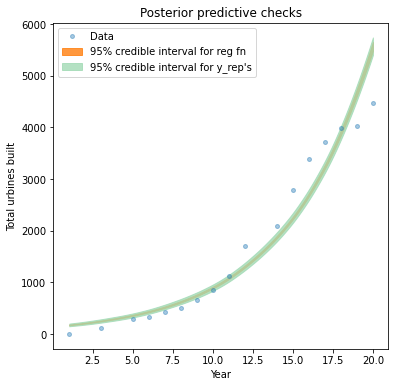

In [25]:
_, ax = plt.subplots(figsize = (6,6))

ax.plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
az.plot_hpd(
    ok_turbines.year,
    y_hat_poisson,
    ax=ax,
    credible_interval=0.95,
    fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
)
az.plot_hpd(
    ok_turbines.year,
    poisson_ppc["y"],
    ax=ax,
    credible_interval=0.95,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
)

ax.set_xlabel("Year")
ax.set_ylabel("Total urbines built")
ax.set_title("Posterior predictive checks")
ax.legend(fontsize=10);

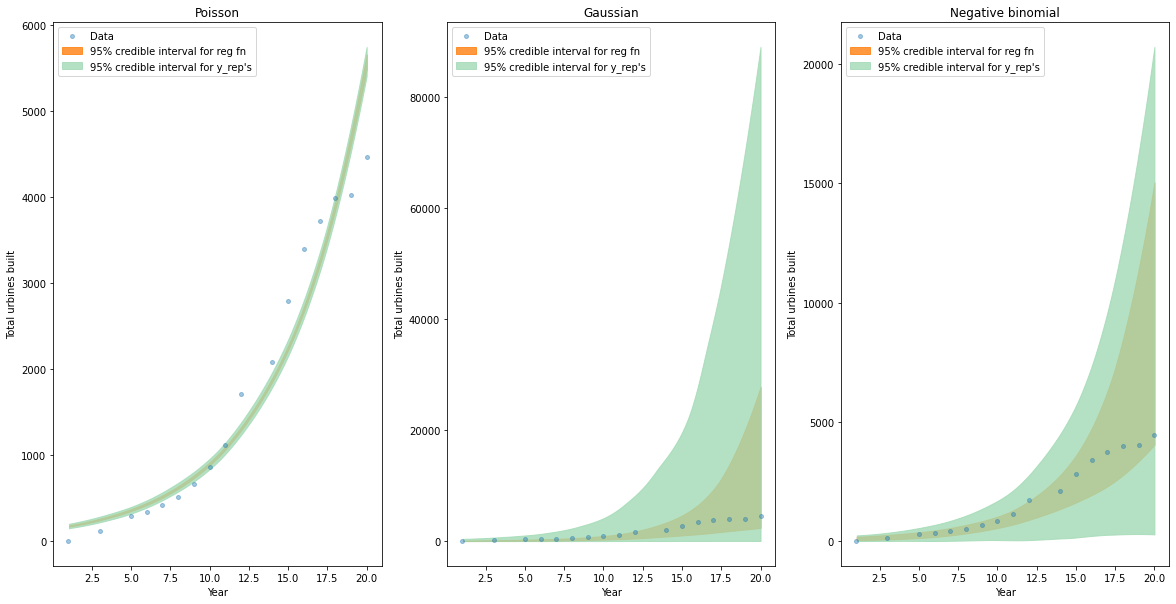

In [27]:
_, ax = plt.subplots(1,3, figsize = (20,10))
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(ok_turbines.year, ok_turbines.totals, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hpd(
        ok_turbines.year,
        y_hat_vals[idx],
        ax=ax[idx],
        credible_interval=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]
    az.plot_hpd(
        ok_turbines.year,
        pp_y,
        ax=ax[idx],
        credible_interval=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax[idx].set_xlabel("Year")
    ax[idx].set_ylabel("Total urbines built")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)